In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from net import *
from utils import *
from loss import *

In [2]:
img_root = "D:/nyc_taxi/data_min_max"
test_imgs = np.load(img_root+'/test.npy')
val_imgs = np.load(img_root+'/val.npy')

### Modeling

In [3]:
## parameters
img_root = "D:/nyc_taxi/data_min_max"
mask_root = "D:/nyc_taxi/data_min_max"
image_size = 64
chunk_size = 5
mape_loss = 0
test_imgs = np.load(img_root+'/test.npy')
test_masks_random = np.load(mask_root+'/test_random_mask.npy')
dataset_test = taxi_data(test_imgs, test_masks_random, image_size, chunk_size)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## load models
model = PConvUNet(chunk_size=chunk_size)
model.load_state_dict(torch.load(f'../../model_states/chunk_size_{chunk_size}/biased_{mape_loss}'))
model.eval()

### Inverse Parade

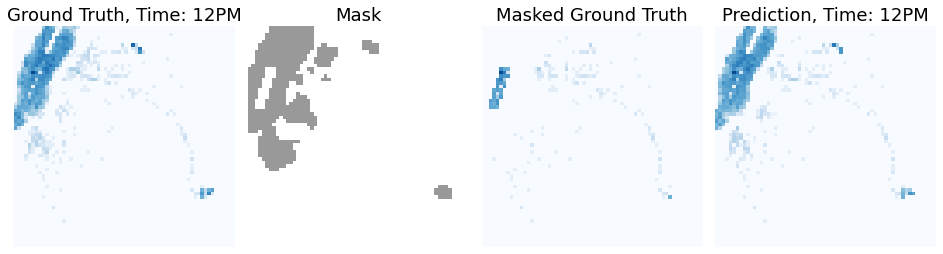

In [4]:
## param
color = 'Blues'
all_time_max = 1428
indices = [3516]
_, gt = zip(*[dataset_test[i] for i in indices])
mask, _ = zip(*[dataset_test[i] for i in indices])
mask = torch.stack(mask)

## mask
img = np.zeros((64,64))
img = np.load(f'D:/nyc_taxi/data_min_max/train.npy')[0]
blurred = cv2.GaussianBlur(img, (5,5), 0)
thresh = cv2.threshold(blurred, np.quantile(blurred.ravel(), 0.85), 1, cv2.THRESH_BINARY)[1]
mask[:,:,-1,:,:] = 1-torch.from_numpy(thresh)
mask[:,:,-1,12, 5:8] = 1
mask[:,:,-1,13, 5:8] = 1
mask[:,:,-1,14, 5:8] = 1
mask[:,:,-1,15, 4:7] = 1
mask[:,:,-1,16, 4:7] = 1
mask[:,:,-1,17, 4:7] = 1
mask[:,:,-1,18, 3:6] = 1
mask[:,:,-1,19, 3:6] = 1
mask[:,:,-1,20, 3:6] = 1
mask[:,:,-1,21, 2:5] = 1
mask[:,:,-1,22, 2:5] = 1
mask[:,:,-1,23, 2:5] = 1
gt = torch.stack(gt)
image = mask*gt

with torch.no_grad():
    output, _ = model(gt, mask)
output_comp = mask * gt + (1 - mask) * output

## scale back + log transformation
gt = torch.log(gt*all_time_max+1) 
image = torch.log(image*all_time_max+1)
output_comp = torch.log(output_comp*all_time_max+1)

## the last layer
index = 4
gt = gt[:,:,index,:,:]
mask = mask[:,:,index,:,:]
image = image[:,:,index,:,:]
output_comp = output_comp[:,:,index,:,:]

## visualizations
VMAX=7
fig_size = 16
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(fig_size,fig_size))
fontsize = 18
ax1.imshow(gt[0][0],vmin=0, vmax=VMAX,cmap='Blues')
ax1.set_title(f'Ground Truth, Time: 12PM', size=fontsize)
ax1.axis('off')
ax2.imshow(mask[0][0],cmap='gray', vmin=-1.5)
ax2.set_title('Mask', size=fontsize)
ax2.axis('off')
ax3.imshow(image[0][0],vmin=0, vmax=VMAX,cmap='Blues')
ax3.set_title('Masked Ground Truth', size=fontsize)
ax3.axis('off')
ax4.imshow(output_comp[0][0],vmin=0, vmax=VMAX,cmap='Blues')
ax4.set_title(f'Prediction, Time: 12PM', size=fontsize)
ax4.axis('off')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.06, 
                    hspace=-0.63)

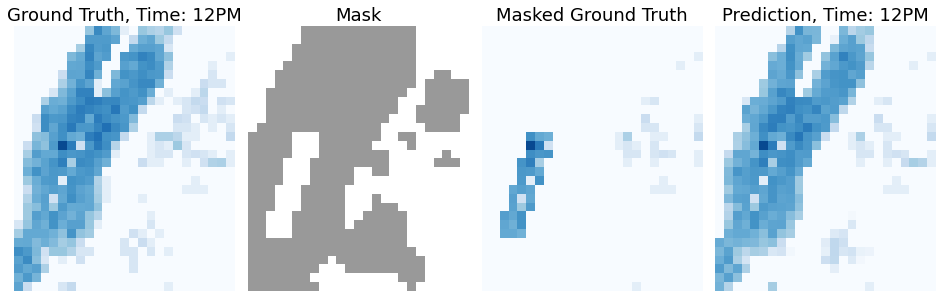

In [10]:
## visualizations
VMAX=7
fig_size = 16
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(fig_size,fig_size))
fontsize = 18
long_boundary = 25
lat_boundary = 30
ax1.imshow(gt[0][0][:lat_boundary, :long_boundary],vmin=0, vmax=VMAX,cmap='Blues')
ax1.set_title(f'Ground Truth, Time: 12PM', size=fontsize)
ax1.axis('off')
ax2.imshow(mask[0][0][:lat_boundary, :long_boundary],cmap='gray', vmin=-1.5)
ax2.set_title('Mask', size=fontsize)
ax2.axis('off')
ax3.imshow(image[0][0][:lat_boundary, :long_boundary],vmin=0, vmax=VMAX,cmap='Blues')
ax3.set_title('Masked Ground Truth', size=fontsize)
ax3.axis('off')
ax4.imshow(output_comp[0][0][:lat_boundary, :long_boundary],vmin=0, vmax=VMAX,cmap='Blues')
ax4.set_title(f'Prediction, Time: 12PM', size=fontsize)
ax4.axis('off')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.06, 
                    hspace=-0.5)

### Historical Avg

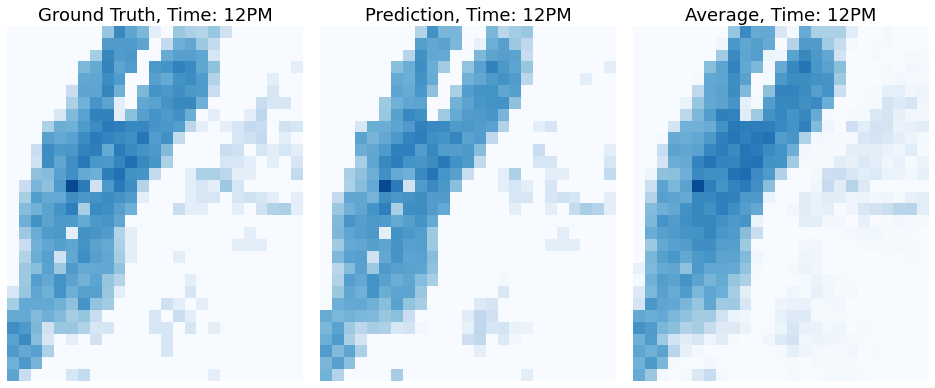

In [11]:
## visualizations
VMAX=7
fig_size = 16
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(fig_size, fig_size))
fontsize = 18
long_boundary = 25
lat_boundary = 30
past_indices = [j for j in range(11,len(test_imgs), 24)]
_, avg_gt = zip(*[dataset_test[i] for i in past_indices])
avg_gt = torch.mean(torch.stack(avg_gt), dim=0, keepdim=True)
avg_gt = avg_gt[:,:,-1,:,:]
avg_gt = torch.log(avg_gt*all_time_max+1)

## visualizations
ax1.imshow(gt[0][0][:lat_boundary, :long_boundary],vmin=0, vmax=VMAX,cmap='Blues')
ax1.set_title(f'Ground Truth, Time: 12PM', size=fontsize)
ax1.axis('off')
ax2.imshow(output_comp[0][0][:lat_boundary, :long_boundary],vmin=0, vmax=VMAX,cmap='Blues')
ax2.set_title(f'Prediction, Time: 12PM', size=fontsize)
ax2.axis('off')
ax3.imshow(avg_gt[0][0][:lat_boundary, :long_boundary],vmin=0, vmax=VMAX,cmap='Blues')
ax3.set_title(f'Average, Time: 12PM', size=fontsize)
ax3.axis('off')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.06, 
                    hspace=0.1)

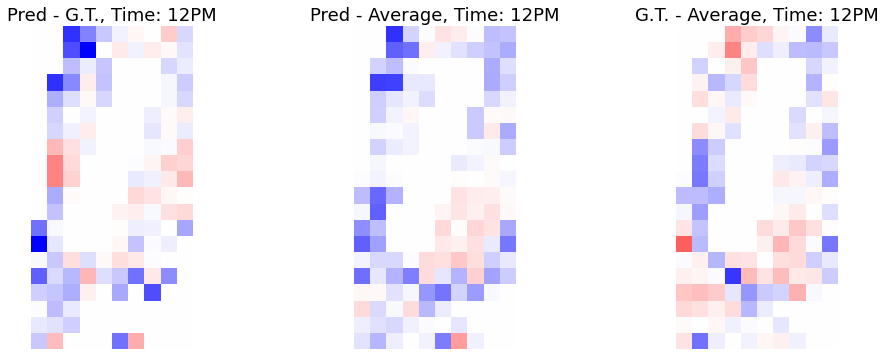

In [23]:
## visualizations
VMAX=2
VMIN=-2
fig_size = 14
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(fig_size,fig_size))
fontsize = 18
long_boundary = 10
lat_upper = 10
lat_lower = 30
past_indices = [j for j in range(11,len(test_imgs), 24)]
_, avg_gt = zip(*[dataset_test[i] for i in past_indices])
avg_gt = torch.mean(torch.stack(avg_gt), dim=0, keepdim=True)
avg_gt = avg_gt[:,:,-1,:,:]
avg_gt = torch.log(avg_gt*all_time_max+1)

## visualizations
ax1.imshow(((1-mask[0][0])*output_comp[0][0])[lat_upper:lat_lower, :long_boundary]-\
          ((1-mask[0][0])*gt[0][0])[lat_upper:lat_lower, :long_boundary],
          vmin=VMIN, vmax=VMAX,cmap='bwr')
ax1.set_title(f'Pred - G.T., Time: 12PM', size=fontsize)
ax1.axis('off')
ax2.imshow(((1-mask[0][0])*output_comp[0][0])[lat_upper:lat_lower, :long_boundary]-\
          ((1-mask[0][0])*avg_gt[0][0])[lat_upper:lat_lower, :long_boundary],
          vmin=VMIN, vmax=VMAX,cmap='bwr')
ax2.set_title(f'Pred - Average, Time: 12PM', size=fontsize)
ax2.axis('off')
ax3.imshow(((1-mask[0][0])*gt[0][0])[lat_upper:lat_lower, :long_boundary]-\
          ((1-mask[0][0])*avg_gt[0][0])[lat_upper:lat_lower, :long_boundary],
          vmin=VMIN, vmax=VMAX,cmap='bwr')
ax3.set_title(f'G.T. - Average, Time: 12PM', size=fontsize)
ax3.axis('off')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=1, 
                    hspace= 0.2)